<a href="https://colab.research.google.com/drive/1fGsqZIfZN1xpyK_Z6F7iD_uxn4uY52ym?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
from torchvision.io import read_image
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Extract dataset images
!mkdir -p '/content/data/irises'
!unzip '/gdrive/MyDrive/Deep Learning F23 Final Project/Datasets/dataset.zip'

In [ ]:
# Custom dataset class for our model
class IrisPairsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
      self.img_labels = pd.read_csv(annotations_file)
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]).zfill(4) + '.jpg')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
def calculate_mean_and_std(dataset, image_size):
  """
  Calculates the RGB channel means and standard deviations given a IrisPairsDataset
  """
  psum = torch.tensor([0.0,0.0,0.0])
  psum_sq = torch.tensor([0.0,0.0,0.0])
  dataloader = DataLoader(dataset, batch_size=128,  num_workers=2)
  for inputs, labels in dataloader:
    psum += inputs.sum(axis=[0,2,3])
    psum_sq += (inputs**2).sum(axis=[0,2,3])

  count = len(dataset) * image_size[0] * image_size[1]

  # mean and std
  total_mean = psum / count
  total_var  = (psum_sq / count) - (total_mean ** 2)
  total_std  = torch.sqrt(total_var)

  # output
  return total_mean, total_std

In [ ]:
# Calculate RGB mean and std vectors for full dataset
transform_pre_normalization = transforms.Compose([transforms.ConvertImageDtype(dtype=torch.float32)])
dataset_pre_normalization = IrisPairsDataset(annotations_file='/gdrive/MyDrive/Deep Learning F23 Final Project/Datasets/labels.csv',
                           img_dir='/content/content/dataset', transform=transform_pre_normalization)
mean, std = calculate_mean_and_std(dataset_pre_normalization, (96,96))

In [ ]:
# Apply output to above for transform normalization
transform = transforms.Compose([transforms.ConvertImageDtype(dtype=torch.float32),
                                transforms.Normalize(mean, std)] # normalize input to [-1,1]
)

In [ ]:
dataset = IrisPairsDataset(annotations_file='/gdrive/MyDrive/Deep Learning F23 Final Project/Datasets/labels.csv',
                           img_dir='/content/content/dataset', transform=transform)

In [ ]:
# Create training and validation dataloaders
generator1 = torch.Generator().manual_seed(42)
dataset_train, dataset_validation = random_split(dataset, [.8,.2])
dataloaders = {}
dataloaders['train'] = DataLoader(dataset_train, batch_size=128,  num_workers=2)
dataloaders['val'] = DataLoader(dataset_validation, batch_size=128, num_workers=2)

In [ ]:
"""
Beginning of model implementation. Implementation is based on the original paper
and adapted the following repo:
https://github.com/tengshaofeng/ResidualAttentionNetwork-pytorch
Please see our report for further details
"""

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = int(output_channels/4)
        self.output_channels = output_channels
        self.stride = stride
        self.conv1 = nn.Conv2d(input_channels, self.hidden_channels, 1, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.hidden_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(self.hidden_channels, self.hidden_channels, 3, stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(self.hidden_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(self.hidden_channels, output_channels, 1, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(input_channels, output_channels, 1, stride, bias= False) # expands residual input dimension

    def forward(self, x, batch_size=1):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        if self.input_channels != self.output_channels:
          residual = self.conv5(residual)
        out = out + residual
        return out


In [ ]:
class AttentionModule_stage1(nn.Module):
  # Input is 48 x 48
  def __init__(self, input_channels, output_channels,size1=(48,48), size2=(24,24), size3=(12,12)):
    super(AttentionModule_stage1, self).__init__()
    self.first_residual_blocks = ResidualBlock(input_channels, output_channels)

    self.trunk_branches = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels)
      )

    self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask1 = ResidualBlock(input_channels, output_channels)
    self.skip1 = ResidualBlock(input_channels, output_channels)
    self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask2 = ResidualBlock(input_channels, output_channels)
    self.skip2 = ResidualBlock(input_channels, output_channels)
    self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask3 = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels),
    )
    self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)
    self.softmask4 = ResidualBlock(input_channels, output_channels)
    self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)
    self.softmask5 = ResidualBlock(input_channels, output_channels)
    self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
    self.softmask6 = nn.Sequential(
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels , kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )
    self.last_blocks = ResidualBlock(input_channels,output_channels)

  def forward(self, x):
    # p residual blocks
    x = self.first_residual_blocks(x)

    # trunk branch: t residual blocks
    out_trunk = self.trunk_branches(x)

    # softmask branch:
    # downsample from 48x48 to 6x6
    out_mpool1 = self.mpool1(x)
    out_softmask1 = self.softmask1(out_mpool1)
    out_skip1_connection = self.skip1(out_softmask1)
    out_mpool2 = self.mpool2(out_softmask1)
    out_softmask2 = self.softmask2(out_mpool2)
    out_skip2_connection = self.skip2(out_softmask2)
    out_mpool3 = self.mpool3(out_softmask2)
    # upsample from 6x6 to 48x48
    out_softmask3 = self.softmask3(out_mpool3)
    out_interp3 = self.interpolation3(out_softmask3) + out_softmask2
    out = out_interp3 + out_skip2_connection
    out_softmask4 = self.softmask4(out)
    out_interp2 = self.interpolation2(out_softmask4) + out_softmask1
    out = out_interp2 + out_skip1_connection
    out_softmask5 = self.softmask5(out)
    out_interp1 = (self.interpolation1(out_softmask5) + out_trunk)
    # convolution and sigmoid
    out_softmask6 = self.softmask6(out_interp1)

    # Hadamard product
    out = (1 + out_softmask6) * out_trunk

    # p residual blocks
    out_last = self.last_blocks(out)
    return out_last

In [ ]:
class AttentionModule_stage2(nn.Module):
  # Input is 24 x 24
  def __init__(self, input_channels, output_channels, size1=(24,24), size2=(12,12)):
    super(AttentionModule_stage2, self).__init__()
    self.first_residual_blocks = ResidualBlock(input_channels, output_channels)

    self.trunk_branches = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels)
      )

    self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask1 = ResidualBlock(input_channels, output_channels)
    self.skip1 = ResidualBlock(input_channels, output_channels)
    self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask2 = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels),
    )
    self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)
    self.softmask3 = ResidualBlock(input_channels, output_channels)
    self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
    self.softmask4 = nn.Sequential(
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels , kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )
    self.last_blocks = ResidualBlock(input_channels,output_channels)

  def forward(self, x):
    # p residual blocks
    x = self.first_residual_blocks(x)

    # trunk branch: t residual blocks
    out_trunk = self.trunk_branches(x)

    # softmask branch:
    # downsample from 24x24 to 6x6
    out_mpool1 = self.mpool1(x)
    out_softmask1 = self.softmask1(out_mpool1)
    out_skip1_connection = self.skip1(out_softmask1)
    out_mpool2 = self.mpool2(out_softmask1)
    # upsample from 6x6 to 24x24
    out_softmask2 = self.softmask2(out_mpool2)
    out_interp2 = self.interpolation2(out_softmask2) + out_softmask1
    out = out_interp2 + out_skip1_connection
    out_softmask3 = self.softmask3(out)
    out_interp1 = self.interpolation1(out_softmask3) + out_trunk
    # convolution and sigmoid
    out_softmask4 = self.softmask4(out_interp1)

    # Hadamard product
    out = (1 + out_softmask4) * out_trunk

    # p residual blocks
    out_last = self.last_blocks(out)
    return out_last

In [ ]:
class AttentionModule_stage3(nn.Module):
  # Input is 12 x 12
  def __init__(self, input_channels, output_channels, size1=(12,12)):
    super(AttentionModule_stage3, self).__init__()
    self.first_residual_blocks = ResidualBlock(input_channels, output_channels)

    self.trunk_branches = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels)
      )

    self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.softmask1 = nn.Sequential(
        ResidualBlock(input_channels, output_channels),
        ResidualBlock(input_channels, output_channels),
    )
    self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
    self.softmask2 = nn.Sequential(
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels , kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )
    self.last_blocks = ResidualBlock(input_channels,output_channels)

  def forward(self, x):
    # p residual blocks
    x = self.first_residual_blocks(x)

    # trunk branch: t residual blocks
    out_trunk = self.trunk_branches(x)

    # softmask branch:
    # downsample from 12x12 to 6x6
    out_mpool1 = self.mpool1(x)
    # upsample from 6x6 to 12x12
    out_softmask1 = self.softmask1(out_mpool1)
    out_interp1 = self.interpolation1(out_softmask1) + out_trunk
    # convolution and sigmoid
    out_softmask2 = self.softmask2(out_interp1)

    # Hadamard product
    out = (1 + out_softmask2) * out_trunk

    # p residual blocks
    out_last = self.last_blocks(out)
    return out_last

In [ ]:
class ResidualAttention(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3,3), padding=(2), stride=1),
        nn.ReLU(inplace=True)
    )
    self.max_pooling = nn.MaxPool2d(3, stride=2)
    self.residual_block1 = ResidualBlock(16, 64)
    self.attention_stage1 = AttentionModule_stage1(64,64)
    self.residual_block2 = ResidualBlock(64, 128, 2)
    self.attention_stage2 = AttentionModule_stage2(128,128)
    self.residual_block3 = ResidualBlock(128, 256, 2)
    self.attention_stage3 = AttentionModule_stage3(256,256)
    self.residual_block4 = ResidualBlock(256, 512, 2)
    self.residual_block5 = ResidualBlock(512, 512)
    self.residual_block6 = ResidualBlock(512, 512)
    self.avg_pool = nn.AvgPool2d((6,6), 1)
    self.fc = nn.Sequential(
        nn.Linear(512,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.max_pooling(x)
    x = self.residual_block1(x)
    x = self.attention_stage1(x)
    x = self.residual_block2(x)
    x = self.attention_stage2(x)
    x = self.residual_block3(x)
    x = self.attention_stage3(x)
    x = self.residual_block4(x)
    x = self.residual_block5(x)
    x = self.residual_block6(x)
    x = self.avg_pool(x)
    x = x.reshape(-1, 512)
    x = self.fc(x)
    return x

# End of model implementation

In [ ]:
model = ResidualAttention()

In [ ]:
# Prepare arguments for training loop
params = [p for p in model.parameters() if p.requires_grad]
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss = {}
val_loss = {}
num_epochs = 100

In [ ]:
# Training loop
def training_loop(model, criterion, optimizer, parameters, num_epochs=1):
  """
  Executes training loop for binary classifier using BCELoss.
  """
  for epoch in range(num_epochs):
    print(f'EPOCH {epoch}')
    model.to(device)

    for phase in ['train', 'val']:
      running_loss = 0
      running_corrects = 0
      if phase == 'train':
        model.train()
      else:
        model.eval()

      for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            preds = torch.squeeze(outputs)
            loss = criterion(preds, labels.float())

            if phase == 'train':
              loss.backward()
              optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds.round() == labels.data)

        # print every x batches
        if batch_idx % 10 == 0:
          print(f"[{batch_idx}/{len(dataloaders[phase])}] Loss: {loss.item():.4f}")


      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
      if phase == 'train':
        train_loss[epoch] = epoch_loss
      else:
        val_loss[epoch] = epoch_loss

      print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')


In [ ]:
training_loop(model, criterion, optimizer, params, num_epochs)

EPOCH 0
[0/56] Loss: 1.1817
[10/56] Loss: 0.7052
[20/56] Loss: 1.0267
[30/56] Loss: 0.5913
[40/56] Loss: 0.5714
[50/56] Loss: 0.5860
train Loss: 0.7254 Accuracy: 0.7845
[0/14] Loss: 0.4378
[10/14] Loss: 0.5499
val Loss: 0.4747 Accuracy: 0.8006
EPOCH 1
[0/56] Loss: 0.4101
[10/56] Loss: 0.3186
[20/56] Loss: 0.2515
[30/56] Loss: 0.3376
[40/56] Loss: 0.3326
[50/56] Loss: 0.3467
train Loss: 0.3101 Accuracy: 0.8629
[0/14] Loss: 0.3551
[10/14] Loss: 0.4389
val Loss: 0.4341 Accuracy: 0.8203
EPOCH 2
[0/56] Loss: 0.2386
[10/56] Loss: 0.2441
[20/56] Loss: 0.1806
[30/56] Loss: 0.2253
[40/56] Loss: 0.2237
[50/56] Loss: 0.2309
train Loss: 0.2059 Accuracy: 0.9158
[0/14] Loss: 0.2316
[10/14] Loss: 0.2703
val Loss: 0.2985 Accuracy: 0.8885
EPOCH 3
[0/56] Loss: 0.1514
[10/56] Loss: 0.1889
[20/56] Loss: 0.1305
[30/56] Loss: 0.1716
[40/56] Loss: 0.2015
[50/56] Loss: 0.1344
train Loss: 0.1495 Accuracy: 0.9445
[0/14] Loss: 0.1765
[10/14] Loss: 0.2124
val Loss: 0.2435 Accuracy: 0.9076
EPOCH 4
[0/56] Loss: 0.1

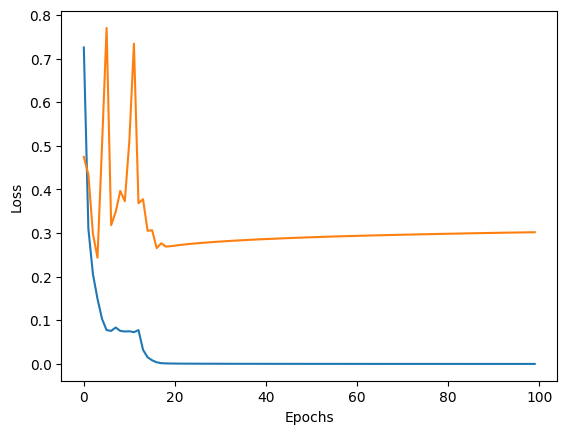

In [ ]:
# Plot training loss curves
plt.plot(range(num_epochs), train_loss.values(), label='Training Loss');
plt.plot(range(num_epochs), val_loss.values(), label='Training Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [ ]:
# Get labels and predictions for valdiation set
val_preds = []
val_labels = []
model.eval()
for images, labels in dataloaders['val']:
  preds = model(images.to(device))
  preds = preds.tolist()
  labels = labels.tolist()
  for pred in preds:
    val_preds.append(pred)
  for label in labels:
    val_labels.append(label)

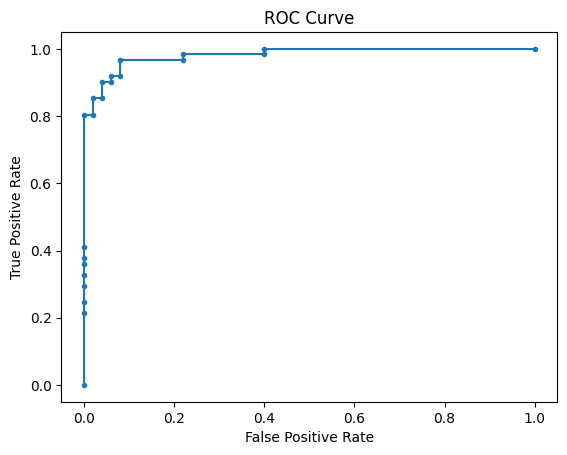

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(labels, preds)
plt.plot(fpr,tpr,marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.title('ROC Curve')
plt.show()

In [ ]:
"""
Calculate optimal classification threshold based on the following tutorial:
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
"""
gmeans = np.sqrt(tpr * (1-fpr))
i = np.argmax(gmeans)
threshold = thresholds[i] # manually tuned for balanced precision and recall
threshold

0.6393391489982605

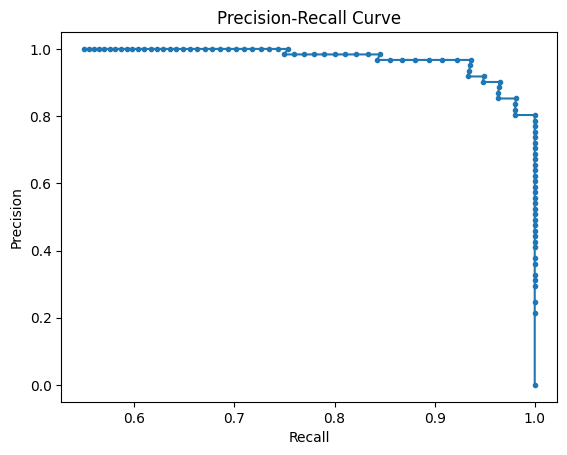

In [ ]:
# Plot Precision Recall Curve
precision, recall, _ = precision_recall_curve(labels, preds)
plt.plot(precision,recall,marker='.')
plt.ylabel('Precision')
plt.xlabel('Recall' )
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# Calculate metrics
classes = np.greater(val_preds, threshold)
accuracy = accuracy_score(val_labels, classes)
precision = precision_score(val_labels, classes)
recall = recall_score(val_labels, classes)
f1 = f1_score(val_labels, classes)
auc = roc_auc_score(val_labels, val_preds)
print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\nAUC: {auc:.2f}')

Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1 Score: 0.93
AUC: 0.97


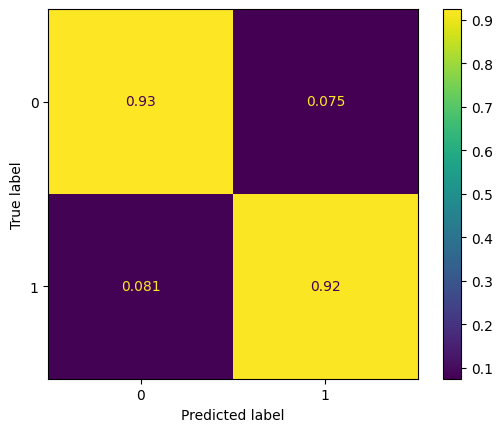

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(val_labels, classes, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[0,1])
disp.plot()
plt.show()